# Predicting NBA Player Points per Game based on Player Characteristics

# Introduction

Basketball is a sport that requires one team to score more points than the other team in order to win. Consequently, players that score more points per game tend to have a higher impact and value than those that do not. Many variables can affect a player’s ability to score, and in this project, we will explore a basketball dataset of NBA players in order to answer the following prediction-focused question:

**How well do the input variables: years of experience, height, and division predict an NBA player’s points per game?**

The dataset was obtained from a Kaggle database, and describes the characteristics of an NBA player, including their physical characteristics (height and weight), basketball statistics, and previous experience. We will be using the following input and response variables.
- PTS (Response): Points per game
- HEIGHT (Input): height in inches
- SEASON_EXP (Input): season/years played
- DIVISION (Input, not part of initial dataset): team division

# Exploratory Data Analysis

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(carData)
library(broom)
library(leaps)
library(mltools)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [3]:
# loading the data
basketball_data <- read_csv("data/Player_Attributes.csv")
head(basketball_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ID = col_double(),
  BIRTHDATE = col_datetime(format = ""),
  HEIGHT = col_double(),
  WEIGHT = col_double(),
  SEASON_EXP = col_double(),
  TEAM_ID = col_double(),
  FROM_YEAR = col_double(),
  TO_YEAR = col_double(),
  PTS = col_double(),
  AST = col_double(),
  REB = col_double(),
  ALL_STAR_APPEARANCES = col_double(),
  PIE = col_double()
)
ℹ Use `spec()` for the full column specifications.




ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,⋯,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24,Duke,USA,⋯,Y,Y,1990,1,25,5.7,0.3,3.3,0,NA
76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07,Iowa State,USA,⋯,Y,Y,1968,1,5,9.0,1.2,8.0,0,NA
76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16,UCLA,USA,⋯,Y,Y,1969,1,1,24.6,3.6,11.2,18,NA
51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09,Louisiana State,USA,⋯,Y,Y,1990,1,3,14.6,3.5,1.9,0,NA
1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03,San Jose State,France,⋯,Y,Y,1997,1,11,7.8,1.1,3.3,0,NA
949,Shareef,Abdur-Rahim,Shareef Abdur-Rahim,"Abdur-Rahim, Shareef",S. Abdur-Rahim,shareef-abdur-rahim,1976-12-11,California,USA,⋯,Y,Y,1996,1,3,18.1,2.5,7.5,1,NA


In [4]:
# selecting the relevant explanatory and response variables
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, TEAM_NAME, PTS) %>%
        filter(!is.na(TEAM_NAME)) %>%
        filter(!is.na(SEASON_EXP)) %>%
        filter(!is.na(HEIGHT)) %>%
        filter(!is.na(PTS))
head(basketball_data)

SEASON_EXP,HEIGHT,TEAM_NAME,PTS
<dbl>,<dbl>,<chr>,<dbl>
4,82,Trail Blazers,5.7
9,81,Rockets,9.0
19,86,Lakers,24.6
8,73,Nuggets,14.6
6,78,Kings,7.8
12,81,Grizzlies,18.1


In [5]:
# classifying teams into their respective divisions from ESPN's current NBA standings
basketball_data <- basketball_data %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Rockets", "Southwest", "ND")) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Grizzlies", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Spurs", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Mavericks", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pelicans", "Southwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Lakers", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Clippers", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Kings", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Suns", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Royals", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Braves", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Warriors", "Pacific", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Jazz", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nuggets", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Timberwolves", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "SuperSonics", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Trail Blazers", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Thunder", "Northwest", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Wizards", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Hornets", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Hawks", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Falcons", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Blackhawks", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bobcats", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bullets", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Heat", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Magic", "Southeast", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bulls", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Bucks", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pistons", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Pacers", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Cavaliers", "Central", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Knicks", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nets", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Raptors", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "76ers", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Nationals", "Atlantic", DIVISION)) %>%
    mutate(DIVISION = ifelse(TEAM_NAME == "Celtics", "Atlantic", DIVISION))
head(basketball_data)
tail(basketball_data)

SEASON_EXP,HEIGHT,TEAM_NAME,PTS,DIVISION
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4,82,Trail Blazers,5.7,Northwest
9,81,Rockets,9.0,Southwest
19,86,Lakers,24.6,Pacific
8,73,Nuggets,14.6,Northwest
6,78,Kings,7.8,Pacific
12,81,Grizzlies,18.1,Southwest


SEASON_EXP,HEIGHT,TEAM_NAME,PTS,DIVISION
<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,80,Bulls,4.7,Central
3,82,Cavaliers,6.0,Central
0,85,Pistons,0.3,Central
0,73,Bucks,2.2,Central
4,84,Clippers,8.5,Pacific
0,75,Capitols,4.9,ND


In [6]:
# Checking to find team names that haven't been classified yet
basketball_nd <- filter(basketball_data, DIVISION == "ND") %>%
group_by(TEAM_NAME) %>%
summarize(mean = mean(SEASON_EXP))
print(basketball_nd$TEAM_NAME)

 [1] "Bombers"      "Capitols"     "Huskies"      "Ironmen"      "Jets"        
 [6] "Olympians"    "Packers"      "Rebels"       "Redskins"     "Stags"       
[11] "Steamrollers" "Zephyrs"     


In [7]:
# Omitting unclassified rows
basketball_data <- basketball_data %>%
    filter(!TEAM_NAME %in% c("Bombers", "Capitols", "Huskies", "Ironmen", "Jets", "Olympians", "Packers", "Rebels", "Redskins", "Stags", "Steamrollers", "Zephyrs"))
head(basketball_data)
tail(basketball_data)

SEASON_EXP,HEIGHT,TEAM_NAME,PTS,DIVISION
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4,82,Trail Blazers,5.7,Northwest
9,81,Rockets,9.0,Southwest
19,86,Lakers,24.6,Pacific
8,73,Nuggets,14.6,Northwest
6,78,Kings,7.8,Pacific
12,81,Grizzlies,18.1,Southwest


SEASON_EXP,HEIGHT,TEAM_NAME,PTS,DIVISION
<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,84,Magic,1.2,Southeast
1,80,Bulls,4.7,Central
3,82,Cavaliers,6.0,Central
0,85,Pistons,0.3,Central
0,73,Bucks,2.2,Central
4,84,Clippers,8.5,Pacific


In [8]:
# final / tidied data
basketball_data <- basketball_data %>%
    select(SEASON_EXP, HEIGHT, PTS, DIVISION)
head(basketball_data)
tail(basketball_data)

SEASON_EXP,HEIGHT,PTS,DIVISION
<dbl>,<dbl>,<dbl>,<chr>
4,82,5.7,Northwest
9,81,9.0,Southwest
19,86,24.6,Pacific
8,73,14.6,Northwest
6,78,7.8,Pacific
12,81,18.1,Southwest


SEASON_EXP,HEIGHT,PTS,DIVISION
<dbl>,<dbl>,<dbl>,<chr>
1,84,1.2,Southeast
1,80,4.7,Central
3,82,6.0,Central
0,85,0.3,Central
0,73,2.2,Central
4,84,8.5,Pacific


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



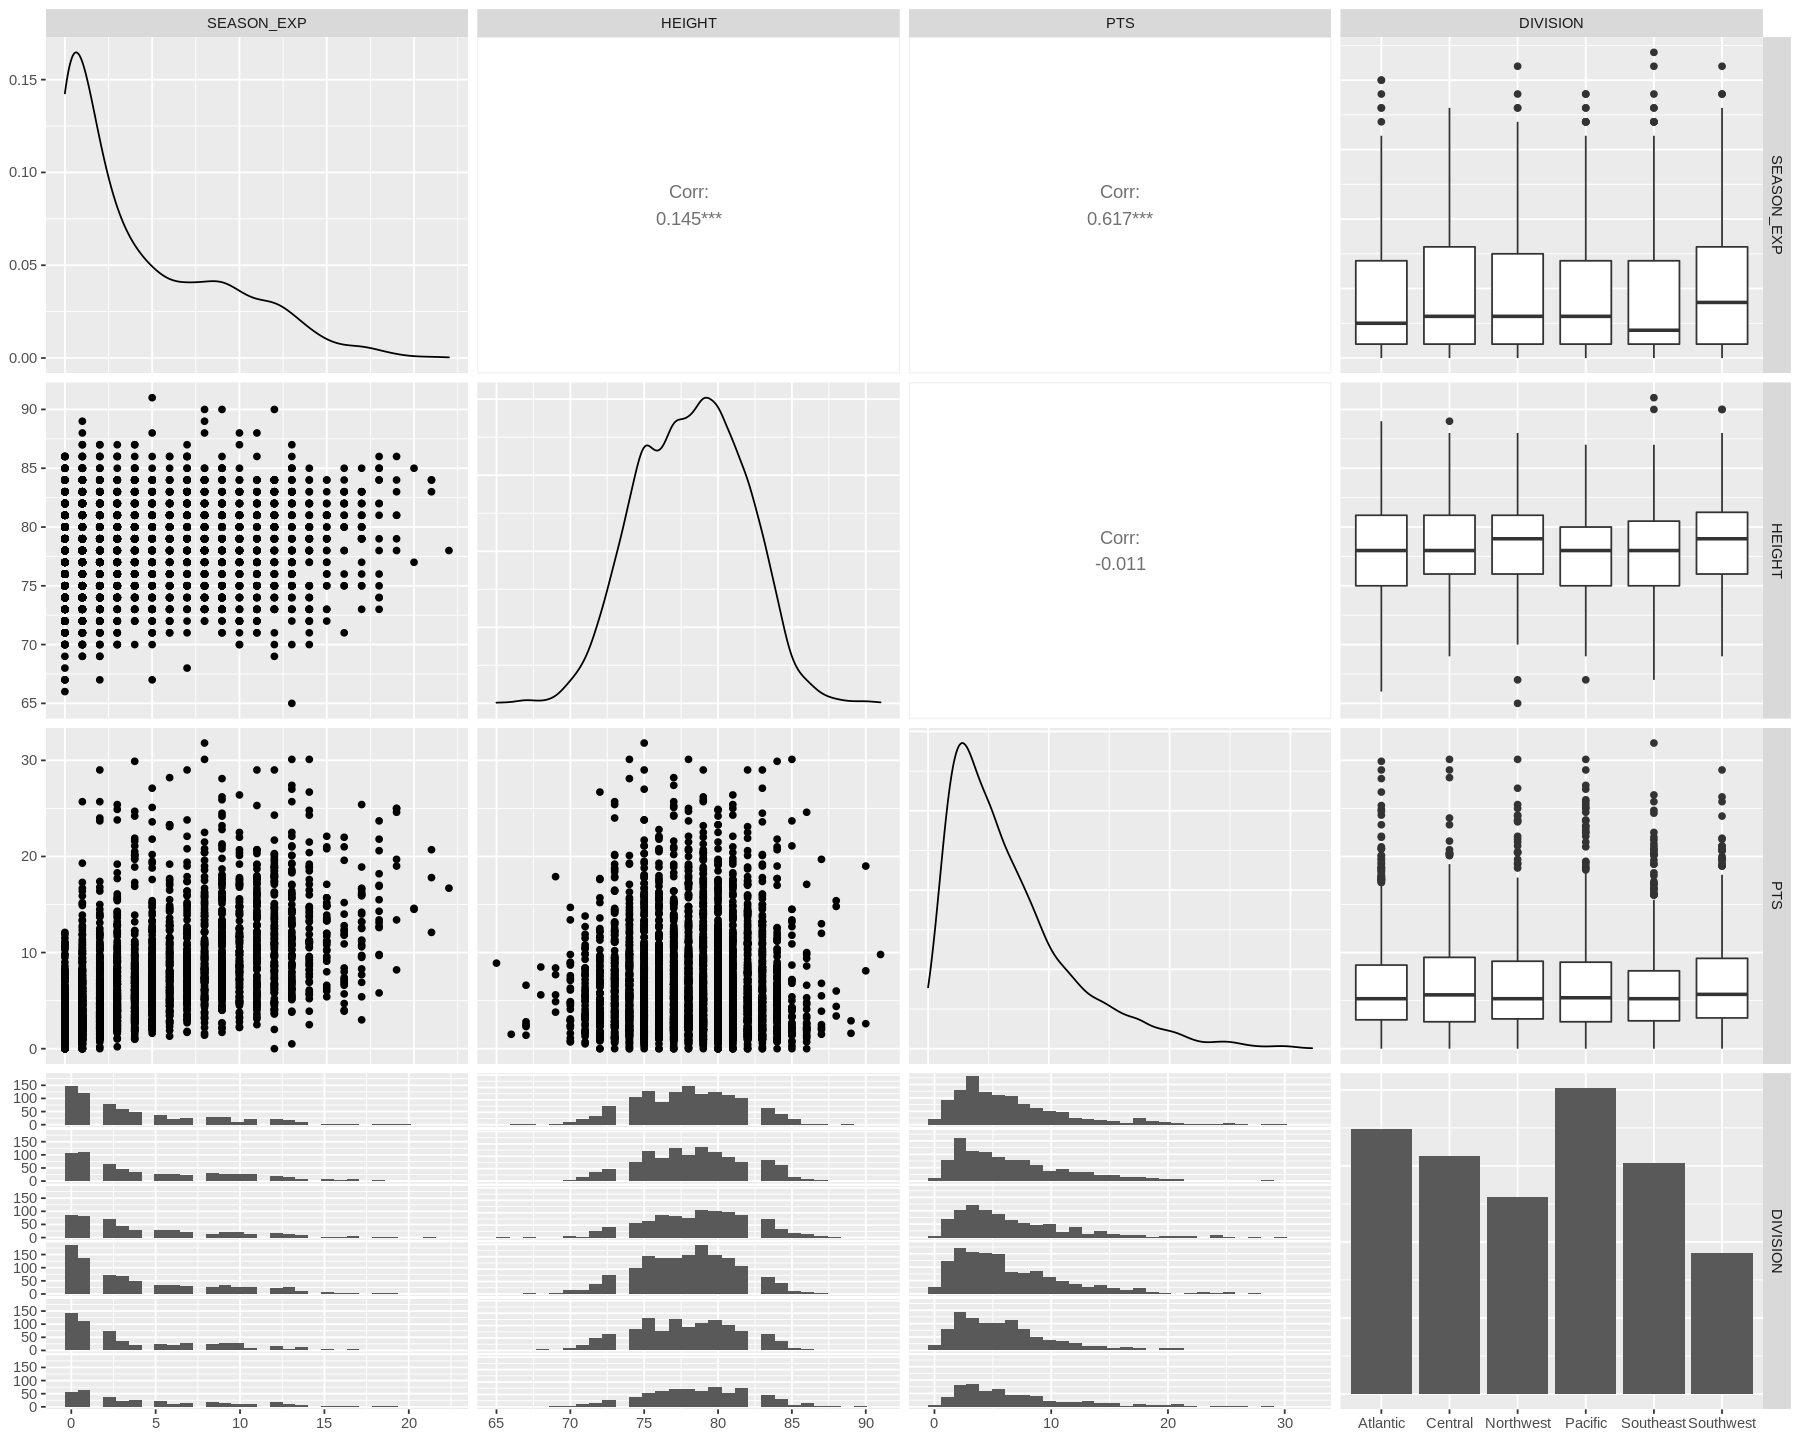

In [9]:
# looking at the association between the variables to get a brief idea
options(repr.plot.width = 15, repr.plot.height = 12)
ggpairs(basketball_data)

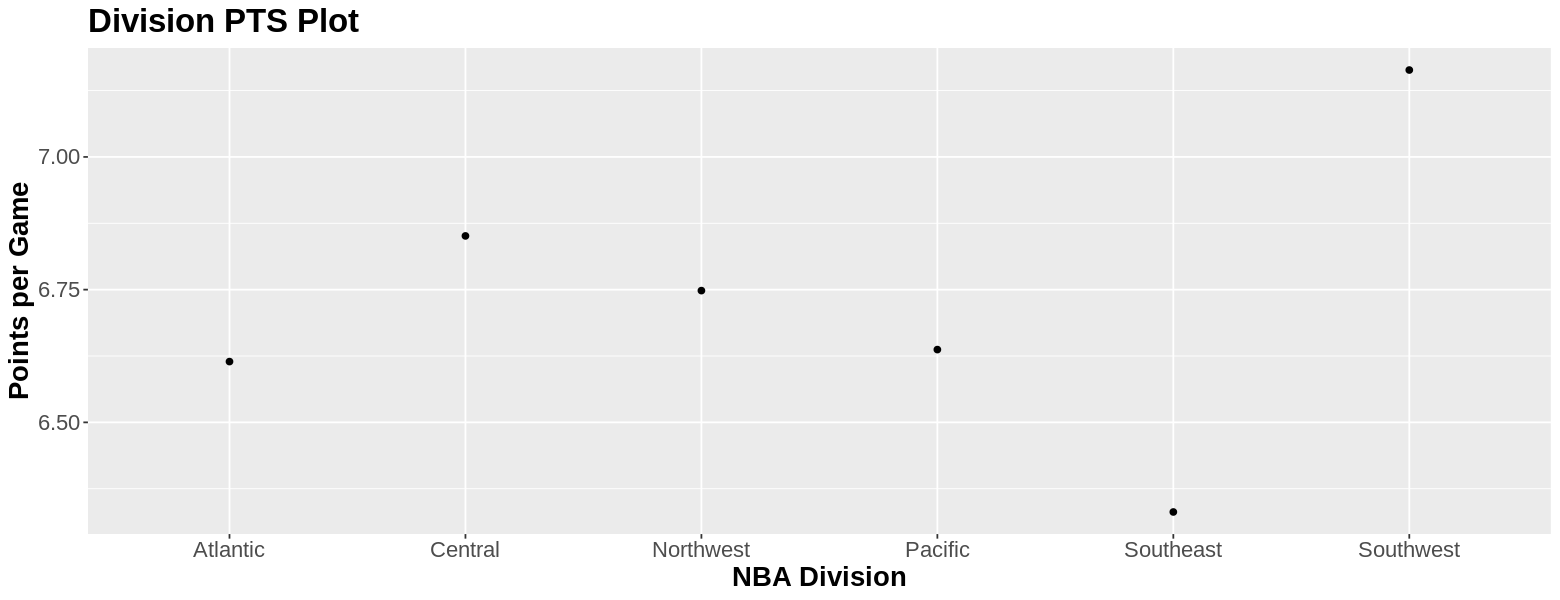

In [10]:
# Plotting the divisions against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_division_data <- basketball_data %>%
    group_by(DIVISION) %>%
    summarize(mean_PTS = mean(PTS))

bb_division_plot <- ggplot(bb_division_data, aes(
  x = DIVISION, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "NBA Division", y = "Points per Game", title = "Division PTS Plot")
bb_division_plot

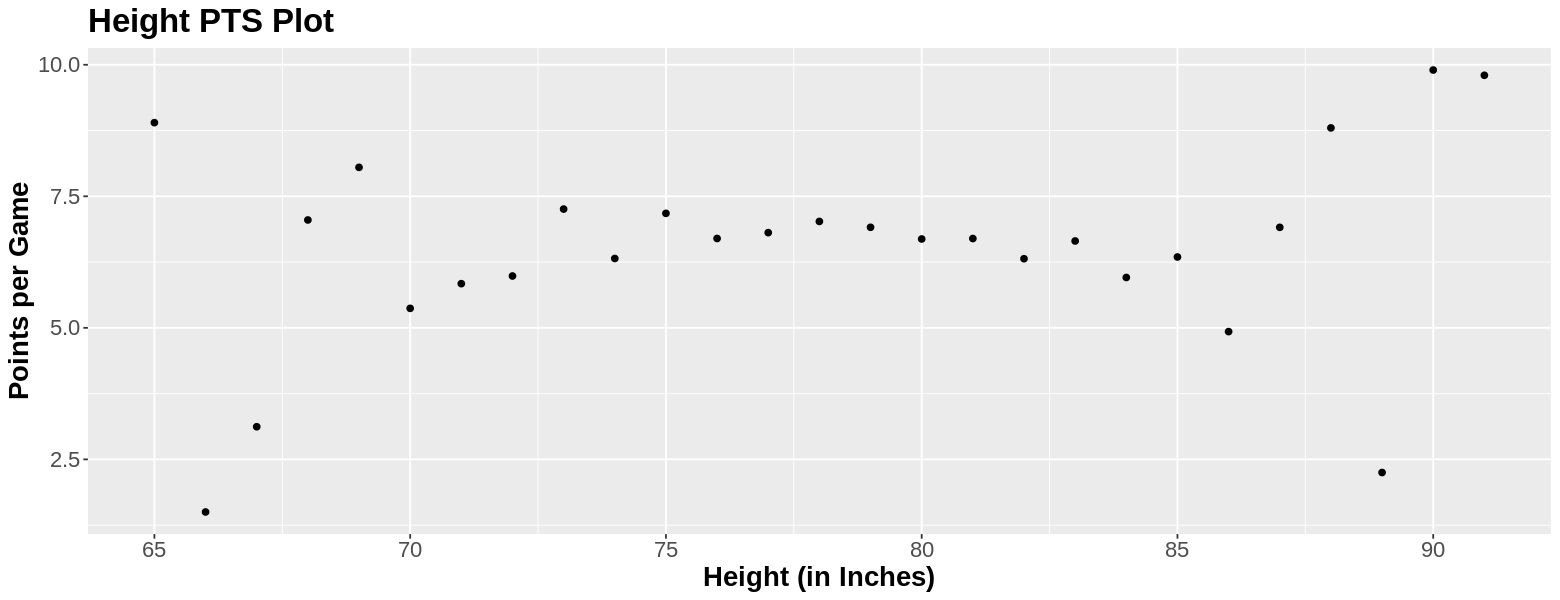

In [11]:
# Plotting the heights against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_height_data <- basketball_data %>%
    group_by(HEIGHT) %>%
    summarize(mean_PTS = mean(PTS))

bb_height_plot <- ggplot(bb_height_data, aes(
  x = HEIGHT, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Height (in Inches)", y = "Points per Game", title = "Height PTS Plot")
bb_height_plot

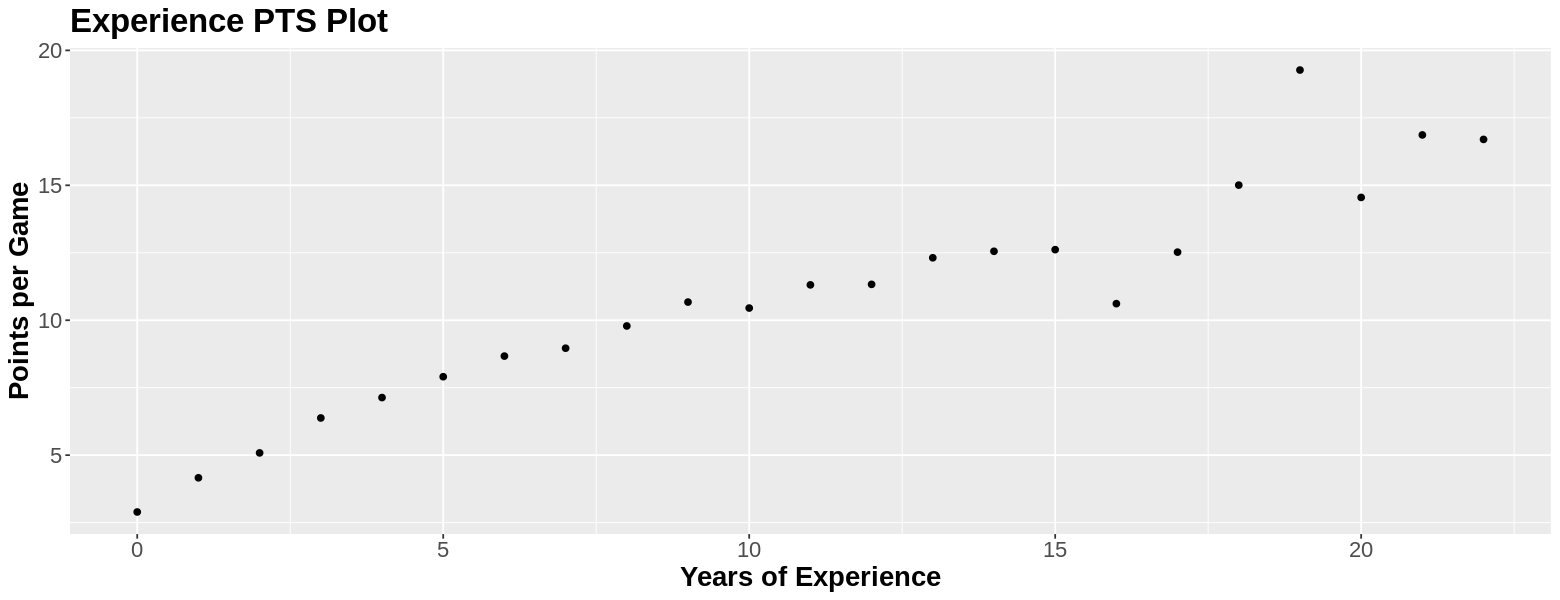

In [12]:
# Plotting the years of experience against their mean points per game
options(repr.plot.width = 13, repr.plot.height = 5)

bb_exp_data <- basketball_data %>%
    group_by(SEASON_EXP) %>%
    summarize(mean_PTS = mean(PTS))

bb_exp_plot <- ggplot(bb_exp_data, aes(
  x = SEASON_EXP, y = mean_PTS)) +
  geom_point() +
  theme(
    text = element_text(size = 16.5),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  labs(x = "Years of Experience", y = "Points per Game", title = "Experience PTS Plot")
bb_exp_plot

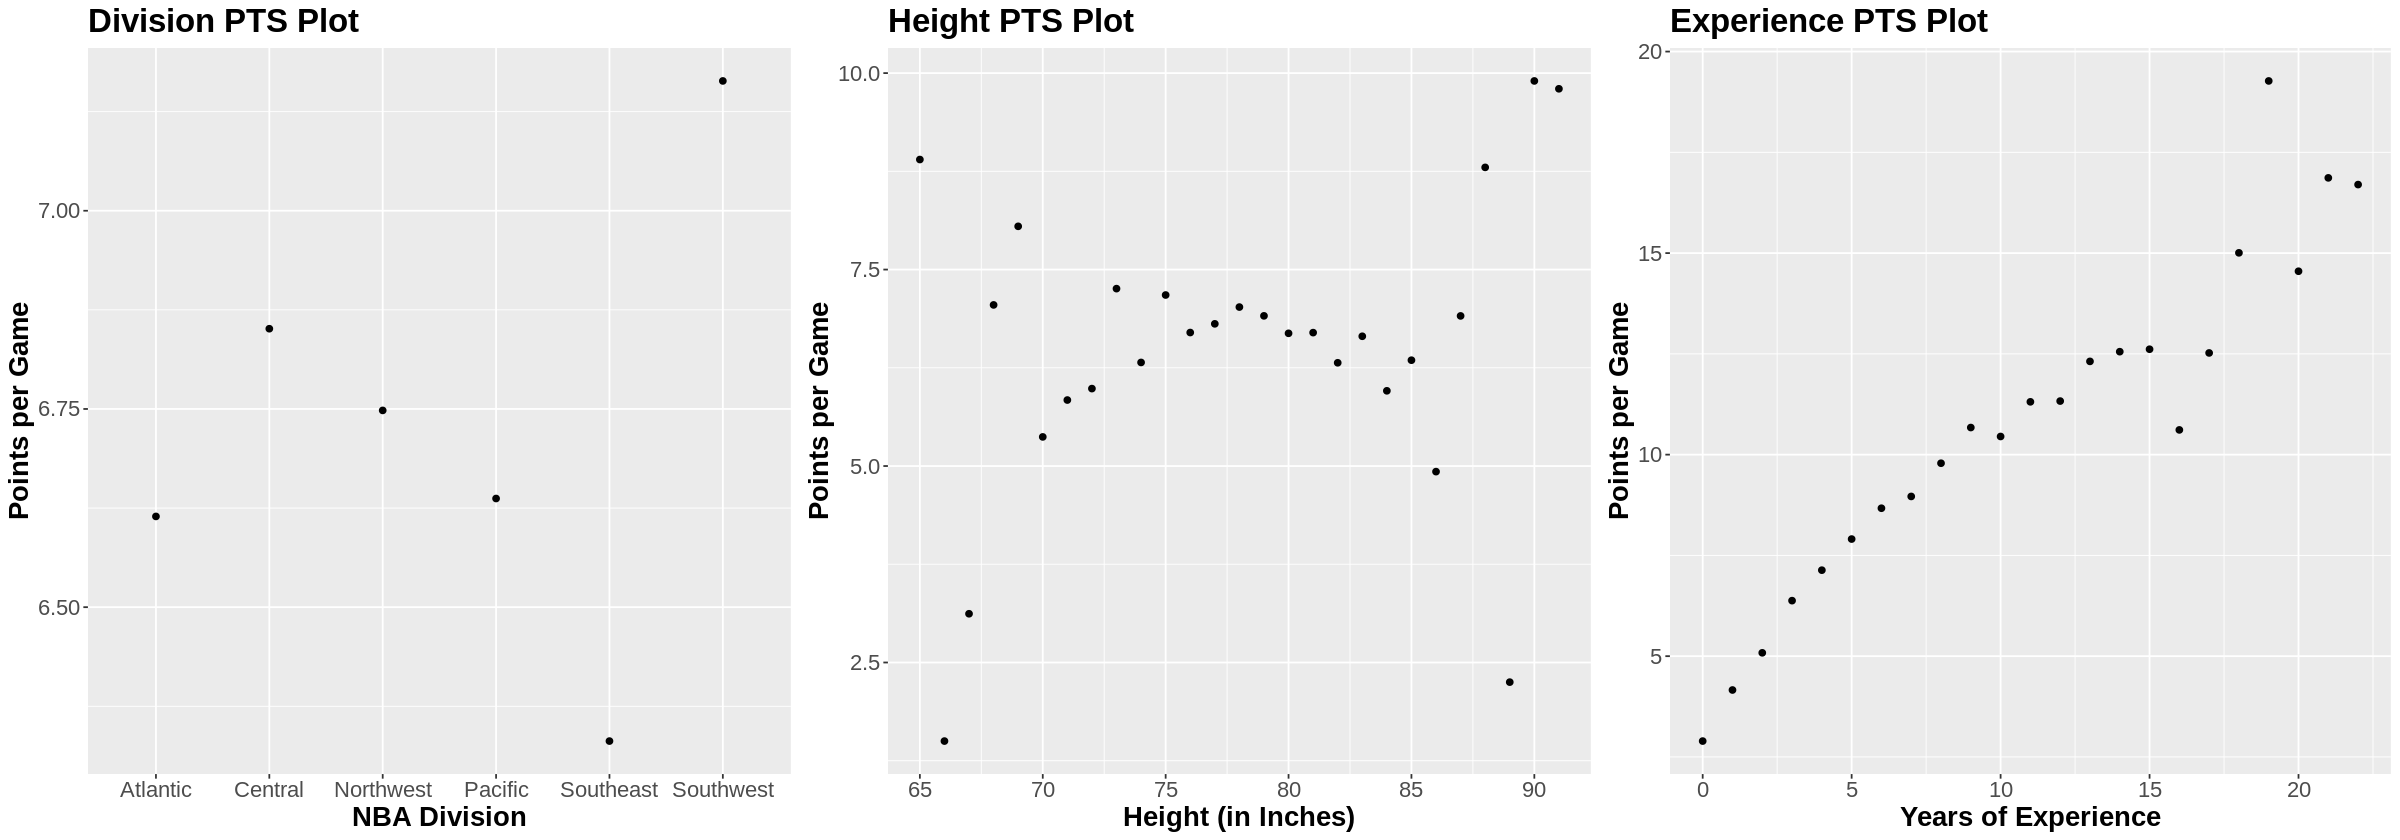

In [13]:
# Viewing them side by side
options(repr.plot.width = 20, repr.plot.height = 7)
grid.arrange(bb_division_plot, bb_height_plot, bb_exp_plot, ncol = 3)

# Methods: Plan

**What methods do you plan on using?**

We will split the whole dataset into training and test datasets. Then we will use the variable selection strategy to choose the best model for prediction. After the model is selected, we will visualize the test data points and the model combining with other statistics to see how the model performs.

**What do you expect to achieve?**


**What impact could your results have?**

Team building is something that could be impacted by our results, as organizations could become biased towards younger or older players, or players of a certain height. Sports betting could also be influenced in that bettors would place higher priority in betting on players from certain NBA divisions. Player salaries could also be affected, as players with desired attributes could receive larger contracts.

# References

- Basketball data. Retrieved from https://www.kaggle.com/wyattowalsh/basketball
- 2021-22 NBA Standings. (n.d.). Retrieved from https://www.espn.com/nba/standings/_/group/division